In [10]:
# %matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import trades, plots, params, strategies
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(strategies)

<module 'libs.strategies' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/strategies.py'>

In [20]:
import os
import math
import pandas as pd
from pathlib import Path
import shutil                     

# pip install alpaca-py pandas pytz
from datetime import datetime, timedelta
import time
import os
import pandas as pd
import pytz
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest, StockQuotesRequest
from alpaca.data.timeframe import TimeFrame

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# from eodhd import APIClient

In [12]:
KEY = os.getenv('ALPACA_KEY_live')
SECRET = os.getenv('ALPACA_SECRET_live')

(None, None)

In [15]:
client = StockHistoricalDataClient(api_key=API_KEY, secret_key=API_SECRET)

client

In [160]:
def fetch_bars(symbol, start, end):
    req = lambda s,e: StockBarsRequest(symbol_or_symbols=[symbol], timeframe=TimeFrame.Minute, start=s, end=e)
    parts = []
    total = (end.date() - start.date()).days + 1
    pbar = tqdm(range(total), desc="loading")
    for i in pbar:
        s = start + timedelta(days=i); e = s + timedelta(days=1)
        pbar.set_description(f"loading {s.date()}")
        parts.append(client.get_stock_bars(req(s, e)).df)
    df = pd.concat(parts).sort_index().xs(symbol, level=0)
    df.index = df.index.tz_convert("UTC").tz_localize(None)
    df.to_csv(params.alpaca_csv)
    return df


loading:   0%|          | 0/10 [00:00<?, ?it/s]

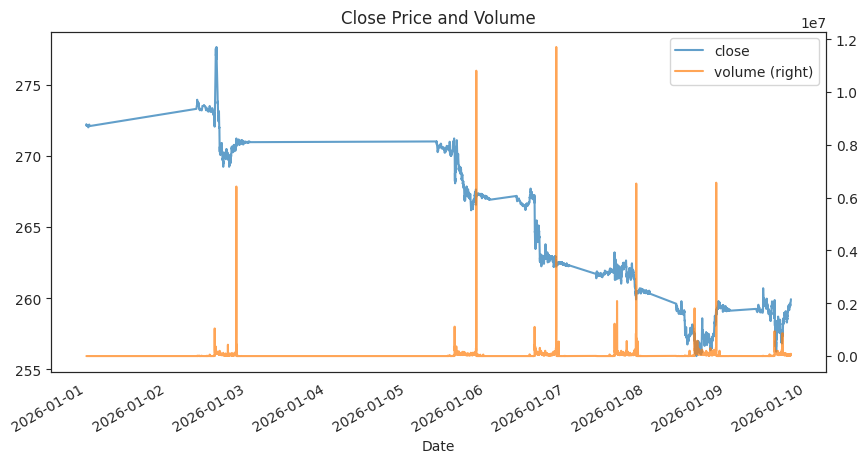

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2026-01-01 00:00:00,272.1400,272.2199,272.1400,272.2199,532.0,12.0,272.195163
2026-01-01 00:01:00,272.1182,272.1182,272.1182,272.1182,370.0,9.0,272.118200
2026-01-01 00:04:00,272.1700,272.1700,272.1700,272.1700,118.0,6.0,272.170000
2026-01-01 00:11:00,272.1200,272.1200,272.1200,272.1200,340.0,6.0,272.120000
2026-01-01 00:14:00,272.1500,272.1500,272.1500,272.1500,400.0,3.0,272.150000
...,...,...,...,...,...,...,...
2026-01-09 19:21:00,259.7200,259.7600,259.6900,259.7600,40595.0,778.0,259.726960
2026-01-09 19:22:00,259.7700,259.8200,259.7600,259.7800,33622.0,700.0,259.789593
2026-01-09 19:23:00,259.7700,259.8550,259.7441,259.8500,72185.0,856.0,259.808036


In [162]:
importlib.reload(params)
start = datetime(2016, 1, 1, 0, 0, tzinfo=pytz.UTC)
end   = datetime(2026, 1, 10, 0, 0, tzinfo=pytz.UTC)

df = fetch_bars("AAPL", start, end)
plots.plot_close_volume(df)
df


In [170]:
# session cumulative VWAP using OHLC4 * volume / cumulative volume
ohlc4 = (df["open"] + df["high"] + df["low"] + df["close"]) / 4.0
df2 = df.copy()
df2["_pv_ohlc4"] = ohlc4 * df2["volume"]
session_vwap_ohlc4 = (df2.groupby(df2.index.date)["_pv_ohlc4"].cumsum() /
                      df2.groupby(df2.index.date)["volume"].cumsum())

tol = 1e-9
diff_ohlc4 = df["vwap"] - session_vwap_ohlc4
cmp_ohlc4 = (diff_ohlc4.abs() <= tol)

print(cmp_ohlc4.groupby(df.index.date).all())
print("max_abs_diff_ohlc4:", diff_ohlc4.abs().max(), "mean_diff_ohlc4:", diff_ohlc4.mean())
print("fraction within 1e-6_ohlc4:", (diff_ohlc4.abs() <= 1e-6).mean())


2026-01-01    False
2026-01-02    False
2026-01-03    False
2026-01-05    False
2026-01-06    False
2026-01-07    False
2026-01-08    False
2026-01-09    False
dtype: bool
max_abs_diff_ohlc4: 4.35980985639452 mean_diff_ohlc4: -0.4737886238095958
fraction within 1e-6_ohlc4: 0.0009678199854827002
